In [31]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import gensim
from gensim import corpora, models, similarities
import os
import utility_synopsis
import math
import numpy as np
from numpy import linalg as la
from scipy.spatial.distance import cosine
import pandas as pd
import matplotlib.pyplot as plt
from surprise import SVD
from surprise import Dataset
from surprise import evaluate, print_perf
from surprise import Reader
import cPickle as pickle
import sqlite3

In [2]:
item_file_name = '/home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/ml-1m/movies.dat' 
item_file_delimiter = '::'

def extract_item_id_list(filename, delimiter):
    item_id_list = []
    with open(filename , 'r') as f:
        for i, line in enumerate(f):
            movieId, title, genres = line.split(delimiter)
            
            item_id_list.append(movieId)
    return item_id_list

item_id_list = extract_item_id_list(item_file_name, item_file_delimiter)

In [3]:

model_path = '/home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=100_min_count=1_window=1_iter=30.model'

#model = gensim.models.Word2Vec.load('/home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=200_min_count=5_window=2.model' )
model = gensim.models.Word2Vec.load(model_path)

2017-03-29 16:47:27,987 : INFO : loading Word2Vec object from /home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=100_min_count=1_window=1_iter=30.model
2017-03-29 16:47:28,290 : INFO : loading wv recursively from /home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=100_min_count=1_window=1_iter=30.model.wv.* with mmap=None
2017-03-29 16:47:28,291 : INFO : setting ignored attribute syn0norm to None
2017-03-29 16:47:28,291 : INFO : setting ignored attribute cum_table to None
2017-03-29 16:47:28,292 : INFO : loaded /home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=100_min_count=1_window=1_iter=30.model


In [4]:
# preparation for calculation of nearest neighbors of a target in content-based approach
genres = ["Action",
"Adventure",
"Animation",
"Children's",
"Comedy",
"Crime",
"Documentary",
"Drama",
"Fantasy",
"Film-Noir",
"Horror",
"Musical",
"Mystery",
"Romance",
"Sci-Fi",
"Thriller",
"War",
"Western",]

genres_index_dict = dict(zip(*[genres, range(len(genres))]))
index_genres_dict = dict(zip(*[range(len(genres)), genres]))

def extract_genres(filename, delimiter, genre_delimiter):
    data = {}

    with open(filename , 'r') as f:
        for i, line in enumerate(f):
            itemId, title, genre_list = map(lambda x: x.strip(), line.split(delimiter))
            
            data[itemId] = genre_list.split(genre_delimiter)
    return data

item_file_name, item_file_delimiter, genre_delimiter = os.path.sep.join(['ml-1m', 'movies.dat']), '::', '|'
item_info = extract_genres(item_file_name, item_file_delimiter, genre_delimiter)

def tmp_set(vec, i, val):
    vec[i] = val
    
def generate_item_repr(item_info):
    item_repr = {}
    for item in item_info:
        #print item
        f = np.array([0] * len(genres))
        map(lambda x: tmp_set(f, genres_index_dict[x], 1), item_info[item])
        #print f
        item_repr[item] = f
        #break
    return item_repr

item_repr = generate_item_repr(item_info)

In [14]:
# preparation for calculation of nearest neighbors of a target in svd approach

algo = None
with open('tmp_svd.algo', 'rb') as f:
    algo = pickle.load(f)

In [13]:
algo

<surprise.prediction_algorithms.matrix_factorization.SVD instance at 0xb60b8f0c>

In [15]:
train_file_name = 'tmp__svd_train'
test_file_name = 'tmp__svd_test'
my_sep = ':'

##
all_item_ids_in_svd_train = set()
with open(train_file_name, 'r') as fin:
    for i, line in enumerate(fin):
        userId, movieId, rating, timestamp = line.split(my_sep)
        all_item_ids_in_svd_train.add(movieId)
##

reader = Reader(line_format='user item rating timestamp', sep=my_sep)

data = Dataset.load_from_folds([(train_file_name, test_file_name)], reader=reader)

for trainset, testset in data.folds():
    first_train, first_test = trainset, testset
    
print 'info of train:'
print first_train.n_users
print first_train.n_items
print first_train.n_ratings

print 'info of test:'
print len(first_test)

info of train:
6040
3698
840388
info of test:
159821


In [73]:
first_train.knows_item('2319')

False

In [72]:
first_train.to_inner_iid('1')

36

In [77]:
np.shape(algo.qi)

(3698, 100)

In [16]:
def generate_svd_item_repr(item_info):
    item_repr = {}
    svd_missing_count = 0
    for item in item_info:
        
        try:
            inner_iid = first_train.to_inner_iid(item)
            item_repr[item] = algo.qi[inner_iid]
        except ValueError, e:
            svd_missing_count += 1
    print 'svd_missing_count:', svd_missing_count
    return item_repr

svd_item_repr = generate_svd_item_repr(item_info)

svd_missing_count: 185


In [100]:
svd_item_repr

{'593': array([ 0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.03571596,  0.03571596,  0.03571596,
         0.03571596,  0.03571596,  0.0357159

In [84]:
model.wv.vocab

{'2031': <gensim.models.word2vec.Vocab at 0xa871768c>,
 '1869': <gensim.models.word2vec.Vocab at 0xa853956c>,
 '1868': <gensim.models.word2vec.Vocab at 0xa853906c>,
 '643': <gensim.models.word2vec.Vocab at 0xa864ed4c>,
 '344': <gensim.models.word2vec.Vocab at 0xa8b0358c>,
 '345': <gensim.models.word2vec.Vocab at 0xa8b030ec>,
 '346': <gensim.models.word2vec.Vocab at 0xa8b0390c>,
 '347': <gensim.models.word2vec.Vocab at 0xa8b0368c>,
 '340': <gensim.models.word2vec.Vocab at 0xa8b03a6c>,
 '341': <gensim.models.word2vec.Vocab at 0xa8b03b8c>,
 '342': <gensim.models.word2vec.Vocab at 0xa8b03cac>,
 '343': <gensim.models.word2vec.Vocab at 0xa8b03bac>,
 '348': <gensim.models.word2vec.Vocab at 0xa849416c>,
 '349': <gensim.models.word2vec.Vocab at 0xa8494a8c>,
 '2318': <gensim.models.word2vec.Vocab at 0xa849446c>,
 '2316': <gensim.models.word2vec.Vocab at 0xa849418c>,
 '2317': <gensim.models.word2vec.Vocab at 0xa84946cc>,
 '2314': <gensim.models.word2vec.Vocab at 0xa8494bcc>,
 '2315': <gensim.mode

In [101]:
print all_item_ids_in_svd_train

set(['1869', '1868', '643', '344', '345', '346', '347', '340', '341', '342', '343', '348', '349', '2318', '2316', '2317', '2314', '2315', '2312', '2313', '2310', '2311', '298', '299', '296', '297', '294', '295', '292', '293', '290', '291', '3773', '3772', '3771', '3770', '3777', '3776', '3775', '3774', '3779', '3778', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '3211', '1780', '581', '3446', '2268', '2269', '2262', '2263', '2260', '2261', '2266', '2267', '2264', '2265', '2442', '2443', '2440', '1130', '2446', '2447', '2444', '1004', '2448', '2449', '2189', '108', '102', '103', '100', '101', '106', '107', '104', '105', '2046', '2047', '2044', '2045', '2042', '2043', '2040', '2041', '2048', '2049', '3150', '1002', '2839', '2737', '2835', '3519', '3518', '3513', '3512', '3511', '3510', '3517', '3516', '3515', '3514', '2688', '2689', '2685', '2686', '2687', '2681', '2682', '2683', '1436', '3390', '645', '1434', '99', '98', '1432', '93', '92', '95', '94', '97', '96

In [39]:

svd_target_repr = svd_item_repr[item_id]
[(iid, svd_target_repr.dot(svd_item_repr[iid]) / 
                     (la.norm(svd_target_repr * la.norm(svd_item_repr[iid])))) for iid in all_item_ids_in_svd_train]


[('1869', -1.0),
 ('1868', 1.0),
 ('643', 1.0000000000000002),
 ('344', -1.0),
 ('345', 0.99999999999999978),
 ('346', 0.99999999999999978),
 ('347', 0.99999999999999978),
 ('340', 1.0),
 ('341', 1.0),
 ('342', 0.99999999999999989),
 ('343', 1.0),
 ('348', 1.0000000000000002),
 ('349', -0.99999999999999978),
 ('2318', 1.0),
 ('2316', -1.0),
 ('2317', 1.0),
 ('2314', 1.0000000000000002),
 ('2315', -1.0),
 ('2312', 0.99999999999999989),
 ('2313', 0.99999999999999989),
 ('2310', 1.0),
 ('2311', 1.0),
 ('298', 1.0),
 ('299', 1.0),
 ('296', 1.0),
 ('297', 0.99999999999999978),
 ('294', 1.0),
 ('295', 1.0000000000000002),
 ('292', -1.0),
 ('293', 1.0),
 ('290', 1.0),
 ('291', -1.0),
 ('3773', -1.0),
 ('3772', 1.0),
 ('3771', 0.99999999999999989),
 ('3770', 0.99999999999999989),
 ('3777', 0.99999999999999989),
 ('3776', 1.0),
 ('3775', 0.99999999999999978),
 ('3774', -1.0),
 ('3779', 1.0),
 ('3778', 1.0),
 ('270', 0.99999999999999978),
 ('271', 1.0),
 ('272', 1.0),
 ('273', -1.000000000000000

In [8]:
# For each item, calculate neighbors of it in content-based approach, word2vec approach and svd approach.
# Analyze their intersection.
import collections as coll

def find_out_intersection_size_sum_with_given_limit_list__x(limit_list):
    intersection_size_map = coll.defaultdict(lambda:coll.defaultdict(list))
    union_size_map = coll.defaultdict(lambda:coll.defaultdict(list))

    missing_count__cb = 0
    missing_count__svd = 0

    i = None
    for __step, item_id in enumerate(item_id_list):
        #print item_id

        if str(item_id) not in model:
            missing_count__cb += 1
            continue
        if str(item_id) not in all_item_ids_in_svd_train:
            missing_count__svd += 1
            continue

        # content-based <START>
        cb_target_repr = item_repr[item_id] # cb: content based
        sims_cb = [(iid, cb_target_repr.dot(item_repr[iid]) / 
                    (la.norm(cb_target_repr * la.norm(item_repr[iid])))) for iid in model.wv.vocab]
        #print sims[0]
        sims_cb = sorted(sims_cb, key=lambda item: -1 * item[1])
        # content-based <END>
       
    
        # svd <START>
        svd_target_repr = svd_item_repr[item_id]
        #print 'svd_target_repr:', svd_target_repr
        sims_svd = [(iid, svd_target_repr.dot(svd_item_repr[iid]) / 
                     (la.norm(svd_target_repr * la.norm(svd_item_repr[iid])))) for iid in all_item_ids_in_svd_train]
        sims_svd = sorted(sims_svd, key=lambda item: -1 * item[1])
        #print 'sims_svd:', sims_svd
        # svd <END>

        # word2vec
        ret_by_word2vec = model.most_similar(str(item_id), topn=max(limit_list))
        
        for limit in limit_list:
            #print(sims[1:limit+1])
            most_similar_by_cb = [x[0] for x in sims_cb[1:limit+1]]  # Careful! The index range!
            #print most_similar_by_cb

            most_similar_by_svd = [x[0] for x in sims_svd[1:limit+1]]  # Careful! The index range!
            
            most_similar_by_word2vec = [x[0] for x in ret_by_word2vec][:limit]  # Careful! The index range! Most similar items by word2vec don't include target item itself.
            #print most_similar_by_word2vec

            
            #print 'cb:', most_similar_by_cb
            #print 'word2vec:', most_similar_by_word2vec
            #print 'svd:', most_similar_by_svd
            
            #print set(most_similar_by_cb).intersection(set(most_similar_by_word2vec))
            inter = set(most_similar_by_cb).intersection(set(most_similar_by_word2vec))
            intersection_size_map[limit]['cb__word2vec'].append(len(inter))
            union = set(most_similar_by_cb).union(set(most_similar_by_word2vec))
            union_size_map[limit]['cb__word2vec'].append(len(union))
            
            #
            inter = set(most_similar_by_cb).intersection(set(most_similar_by_svd))
            #                              (len(set(most_similar_by_word2vec).intersection(set(most_similar_by_svd))))
            intersection_size_map[limit]['cb__svd'].append(len(inter))
            union = set(most_similar_by_cb).union(set(most_similar_by_svd))
            union_size_map[limit]['cb__svd'].append(len(union))
            
            inter = set(most_similar_by_word2vec).intersection(set(most_similar_by_svd))
            intersection_size_map[limit]['word2vec__svd'].append(len(inter))
            union = set(most_similar_by_word2vec).union(set(most_similar_by_svd))
            union_size_map[limit]['word2vec__svd'].append(len(union))
                          
        #if 0 < len(inter):
        #    print item_id
        #if 0 == __step:
        #    break

    print 'missing_count__cb:', missing_count__cb
    print 'missing_count__svd:', missing_count__svd

    return intersection_size_map, union_size_map

#r = find_out_intersection_size_sum_with_given_limit_list__x([500])
#r = find_out_intersection_size_sum_with_given_limit_list__x(range(10, 500, 10))
#print r

In [17]:
r = find_out_intersection_size_sum_with_given_limit_list__x(range(10, 500, 10))

2017-03-29 16:58:01,125 : INFO : precomputing L2-norms of word weight vectors


missing_count__cb: 193
missing_count__svd: 0


In [18]:
inter, uni = r
tmp = {}
for k in inter:
    tmp[k] = {}
    for subk in inter[k]:
        tmp[k][subk] = sum(inter[k][subk])

In [24]:
tmp

{10: {'cb__svd': 556, 'cb__word2vec': 74, 'word2vec__svd': 34},
 20: {'cb__svd': 1210, 'cb__word2vec': 262, 'word2vec__svd': 143},
 30: {'cb__svd': 1804, 'cb__word2vec': 471, 'word2vec__svd': 304},
 40: {'cb__svd': 2629, 'cb__word2vec': 744, 'word2vec__svd': 493},
 50: {'cb__svd': 3371, 'cb__word2vec': 1090, 'word2vec__svd': 757},
 60: {'cb__svd': 4308, 'cb__word2vec': 1498, 'word2vec__svd': 1104},
 70: {'cb__svd': 5361, 'cb__word2vec': 1924, 'word2vec__svd': 1515},
 80: {'cb__svd': 6347, 'cb__word2vec': 2462, 'word2vec__svd': 1980},
 90: {'cb__svd': 7220, 'cb__word2vec': 3039, 'word2vec__svd': 2484},
 100: {'cb__svd': 8283, 'cb__word2vec': 3699, 'word2vec__svd': 3051},
 110: {'cb__svd': 9394, 'cb__word2vec': 4350, 'word2vec__svd': 3681},
 120: {'cb__svd': 10526, 'cb__word2vec': 5086, 'word2vec__svd': 4340},
 130: {'cb__svd': 11716, 'cb__word2vec': 5920, 'word2vec__svd': 5055},
 140: {'cb__svd': 12944, 'cb__word2vec': 6814, 'word2vec__svd': 5827},
 150: {'cb__svd': 14319, 'cb__word2vec

In [19]:
inter, uni = r
jaccard = {}
for k in inter:
    jaccard[k] = {}
    for subk in inter[k]:
        jaccard[k][subk] = np.average(np.array(inter[k][subk]) * 1. / np.array(uni[k][subk]))

In [24]:
import sqlite3

In [ ]:
### sqlite3
table_name = "metrcis__chap2_exp3_coefficient"
cx = sqlite3.connect('my_metrics.db')
cur = cx.cursor()

130 cb__word2vec: 0.0217976448948, cb__svd: 0.0492396290507, word2vec__svd: 0.0194940770519
260 cb__word2vec: 0.041848031829, cb__svd: 0.0695572251714, word2vec__svd: 0.0399055904103
390 cb__word2vec: 0.0638970210374, cb__svd: 0.081587692876, word2vec__svd: 0.0581380764763
10 cb__word2vec: 0.00362008160845, cb__svd: 0.0430008179756, word2vec__svd: 0.00178002261619
140 cb__word2vec: 0.0231641188396, cb__svd: 0.0503305589441, word2vec__svd: 0.0210391593694
270 cb__word2vec: 0.0437218801119, cb__svd: 0.0706896918069, word2vec__svd: 0.0413670806001
400 cb__word2vec: 0.0655243152137, cb__svd: 0.0822472513776, word2vec__svd: 0.059583037046
20 cb__word2vec: 0.00545688849699, cb__svd: 0.0355239131908, word2vec__svd: 0.00328092861255
150 cb__word2vec: 0.0247350601648, cb__svd: 0.0521135163991, word2vec__svd: 0.0227453988311
280 cb__word2vec: 0.0453212829466, cb__svd: 0.0719567296224, word2vec__svd: 0.0427748769685
410 cb__word2vec: 0.0670729078851, cb__svd: 0.0830940146626, word2vec__svd: 0.061

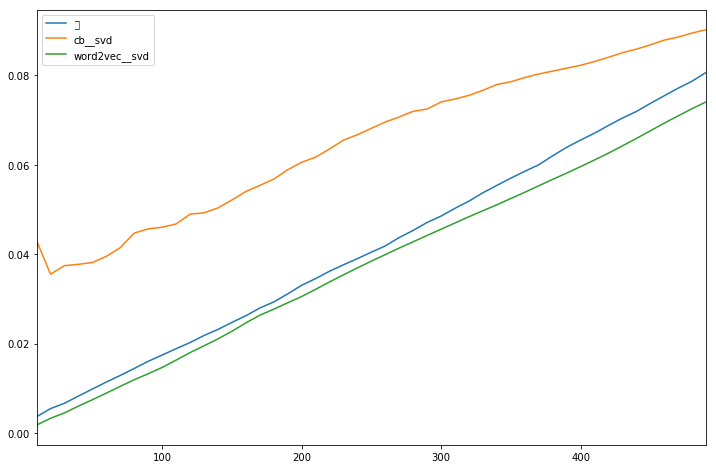

In [33]:
# method 1 to drawing the diagram: calculate all stuff from scratch

cb__word2vec__coll = {}
cb__svd__coll = {}
word2vec__svd__coll = {}
for k in jaccard:
    print k, ', '.join([': '.join([sub_k, str(jaccard[k][sub_k])]) for sub_k in jaccard[k]])
    
    cb__word2vec__coll[k] = jaccard[k]['cb__word2vec']
    cb__svd__coll[k] = jaccard[k]['cb__svd']
    word2vec__svd__coll[k] = jaccard[k]['word2vec__svd']
    
###
cb__word2vec__coll = sorted(cb__word2vec__coll.items(), key=lambda x: x[0])
cb__svd__coll = sorted(cb__svd__coll.items(), key=lambda x: x[0])
word2vec__svd__coll = sorted(word2vec__svd__coll.items(), key=lambda x: x[0])
print cb__word2vec__coll
print cb__svd__coll
print word2vec__svd__coll
    
###
import pandas as pd
import matplotlib.pyplot as plt


indexes = [x[0] for x in cb__word2vec__coll]
values__cb__word2vec = [x[1] for x in cb__word2vec__coll]
values__cb__svd = [x[1] for x in cb__svd__coll]
values__word2vec__svd = [x[1] for x in word2vec__svd__coll]
values = zip(*[values__cb__word2vec, values__cb__svd, values__word2vec__svd])



#table_name = 'tmp'
cur.execute("SELECT COUNT(*) FROM sqlite_master where type='table' and name='%s'" % table_name)
_r = cur.fetchall()
if (0 == _r[0][0]): # Store data only when table dosen't exist.
    for _step, _x in enumerate(indexes):
        cur.execute('insert into %s (K, cb__word2vec, cb__svd, word2vec__svd)' % (table_name) +
                    'values (%d, %.19f, %.19f, %.19f)' % (_x, values[_step][0], values[_step][1], values[_step][2]))
    cx.commit()
else:
    print "\n\n[Note] Table '%s' already exists.\n" % table_name
###

df = pd.DataFrame(values, index=indexes, columns=[u'中', 'cb__svd', 'word2vec__svd'])
df.plot()

fig = plt.gcf()
fig.set_size_inches(12, 8, forward=True)
plt.show()

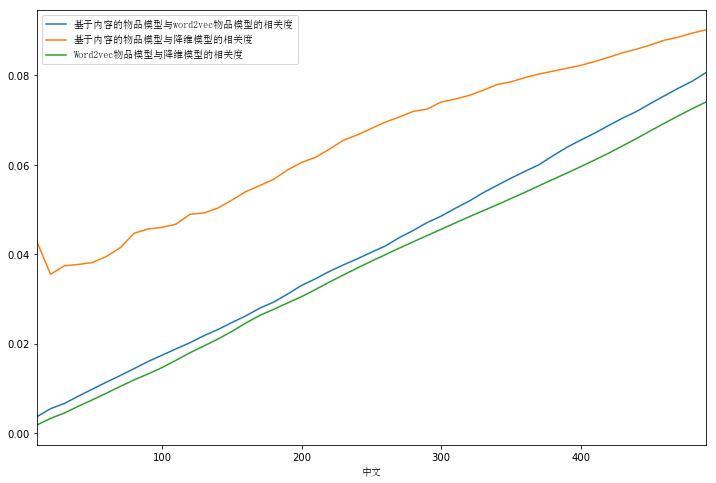

In [56]:
# method 2 to drawing the diagram: load data from database

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager




cur.execute("SELECT COUNT(*) FROM sqlite_master where type='table' and name='%s'" % table_name)
_r = cur.fetchall()
if (1 == _r[0][0]): # Load data when table dose exist.
    
    cur.execute('select K, cb__word2vec, cb__svd, word2vec__svd from %s' % table_name)
    r = cur.fetchall()

    #print r


    indexes = [x[0] for x in cb__word2vec__coll]
    values__cb__word2vec = [x[1] for x in cb__word2vec__coll]
    values__cb__svd = [x[1] for x in cb__svd__coll]
    values__word2vec__svd = [x[1] for x in word2vec__svd__coll]
    values = zip(*[values__cb__word2vec, values__cb__svd, values__word2vec__svd])


    df = pd.DataFrame(values, index=indexes, columns=[u'基于内容的物品模型与word2vec物品模型的相关度', #cb_word2vec
                                                      u'基于内容的物品模型与降维模型的相关度', #cb__svd', 
                                                      u'Word2vec物品模型与降维模型的相关度', #word2vec_svd
                                                     ])
    ax = df.plot()
    # setting font which supports Chinese to enable Chinese legend
    legend = ax.legend()
    font = font_manager.FontProperties(fname='/home/wsyj/Downloads/simsun.ttc')

    for text in legend.texts:
        text.set_font_properties(font)
    
    #
    #ax.set_ylabel('Count')
    #ax.set_xlabel(u'中')
    ##ax.get_xlabel().
    
    #plt.xlabel('xlabel')
    plt.xlabel(u'中文', fontproperties=font)
    
    
    # setting graph size
    fig = plt.gcf()
    fig.set_size_inches(12, 8, forward=True)
    plt.show()

else:
    print '[Error]: Table \'%s\' does not exist.' % table_name

In [132]:
cb__word2vec__coll = {}
cb__svd__coll = {}
word2vec__svd__coll = {}
for k in r:
    print k, ', '.join([': '.join([sub_k, str(r[k][sub_k])]) for sub_k in r[k]])
    
    cb__word2vec__coll[k] = r[k]['cb__word2vec']
    cb__svd__coll[k] = r[k]['cb__svd']
    word2vec__svd__coll[k] = r[k]['word2vec__svd']

130 cb__word2vec: 5958, cb__svd: 11716, word2vec__svd: 5048
260 cb__word2vec: 22303, cb__svd: 34320, word2vec__svd: 20303
390 cb__word2vec: 49643, cb__svd: 61601, word2vec__svd: 44387
10 cb__word2vec: 75, cb__svd: 556, word2vec__svd: 34
140 cb__word2vec: 6820, cb__svd: 12944, word2vec__svd: 5814
270 cb__word2vec: 24076, cb__svd: 36319, word2vec__svd: 21826
400 cb__word2vec: 52106, cb__svd: 63821, word2vec__svd: 46685
20 cb__word2vec: 264, cb__svd: 1210, word2vec__svd: 141
150 cb__word2vec: 7812, cb__svd: 14319, word2vec__svd: 6731
280 cb__word2vec: 25892, cb__svd: 38278, word2vec__svd: 23408
410 cb__word2vec: 54623, cb__svd: 66292, word2vec__svd: 49005
30 cb__word2vec: 468, cb__svd: 1804, word2vec__svd: 304
160 cb__word2vec: 8814, cb__svd: 15859, word2vec__svd: 7659
290 cb__word2vec: 27774, cb__svd: 40054, word2vec__svd: 25051
420 cb__word2vec: 57268, cb__svd: 68751, word2vec__svd: 51412
40 cb__word2vec: 737, cb__svd: 2629, word2vec__svd: 493
170 cb__word2vec: 9932, cb__svd: 17438, wor

In [133]:
cb__word2vec__coll = sorted(cb__word2vec__coll.items(), key=lambda x: x[0])
cb__svd__coll = sorted(cb__svd__coll.items(), key=lambda x: x[0])
word2vec__svd__coll = sorted(word2vec__svd__coll.items(), key=lambda x: x[0])
print cb__word2vec__coll
print cb__svd__coll
print word2vec__svd__coll

[(10, 75), (20, 264), (30, 468), (40, 737), (50, 1095), (60, 1491), (70, 1928), (80, 2464), (90, 3037), (100, 3688), (110, 4340), (120, 5092), (130, 5958), (140, 6820), (150, 7812), (160, 8814), (170, 9932), (180, 11007), (190, 12299), (200, 13704), (210, 14959), (220, 16364), (230, 17748), (240, 19211), (250, 20752), (260, 22303), (270, 24076), (280, 25892), (290, 27774), (300, 29636), (310, 31643), (320, 33647), (330, 35714), (340, 37930), (350, 40150), (360, 42340), (370, 44522), (380, 47014), (390, 49643), (400, 52106), (410, 54623), (420, 57268), (430, 60011), (440, 62651), (450, 65478), (460, 68440), (470, 71296), (480, 74229), (490, 77486)]
[(10, 556), (20, 1210), (30, 1804), (40, 2629), (50, 3371), (60, 4308), (70, 5361), (80, 6347), (90, 7220), (100, 8283), (110, 9394), (120, 10526), (130, 11716), (140, 12944), (150, 14319), (160, 15859), (170, 17438), (180, 19193), (190, 20946), (200, 22719), (210, 24702), (220, 26466), (230, 28583), (240, 30475), (250, 32493), (260, 34320), 

In [1]:
#cb__word2vec__coll = [(10, 75), (20, 264), (30, 468), (40, 737), (50, 1095), (60, 1491), (70, 1928), (80, 2464), (90, 3037), (100, 3688), (110, 4340), (120, 5092), (130, 5958), (140, 6820), (150, 7812), (160, 8814), (170, 9932), (180, 11007), (190, 12299), (200, 13704), (210, 14959), (220, 16364), (230, 17748), (240, 19211), (250, 20752), (260, 22303), (270, 24076), (280, 25892), (290, 27774), (300, 29636), (310, 31643), (320, 33647), (330, 35714), (340, 37930), (350, 40150), (360, 42340), (370, 44522), (380, 47014), (390, 49643), (400, 52106), (410, 54623), (420, 57268), (430, 60011), (440, 62651), (450, 65478), (460, 68440), (470, 71296), (480, 74229), (490, 77486)]
#cb__svd__coll = [(10, 556), (20, 1210), (30, 1804), (40, 2629), (50, 3371), (60, 4308), (70, 5361), (80, 6347), (90, 7220), (100, 8283), (110, 9394), (120, 10526), (130, 11716), (140, 12944), (150, 14319), (160, 15859), (170, 17438), (180, 19193), (190, 20946), (200, 22719), (210, 24702), (220, 26466), (230, 28583), (240, 30475), (250, 32493), (260, 34320), (270, 36319), (280, 38278), (290, 40054), (300, 42239), (310, 44151), (320, 46081), (330, 48214), (340, 50590), (350, 52652), (360, 54766), (370, 56966), (380, 59132), (390, 61601), (400, 63821), (410, 66292), (420, 68751), (430, 71039), (440, 73610), (450, 76203), (460, 78949), (470, 81823), (480, 84517), (490, 87153)]
#word2vec__svd__coll = [(10, 34), (20, 141), (30, 304), (40, 493), (50, 760), (60, 1091), (70, 1522), (80, 1989), (90, 2486), (100, 3051), (110, 3684), (120, 4330), (130, 5048), (140, 5814), (150, 6731), (160, 7659), (170, 8684), (180, 9666), (190, 10842), (200, 12057), (210, 13326), (220, 14621), (230, 15938), (240, 17364), (250, 18811), (260, 20303), (270, 21826), (280, 23408), (290, 25051), (300, 26719), (310, 28421), (320, 30172), (330, 32025), (340, 33957), (350, 35903), (360, 37944), (370, 40075), (380, 42206), (390, 44387), (400, 46685), (410, 49005), (420, 51412), (430, 53880), (440, 56556), (450, 59290), (460, 62097), (470, 64961), (480, 67747), (490, 70603)]

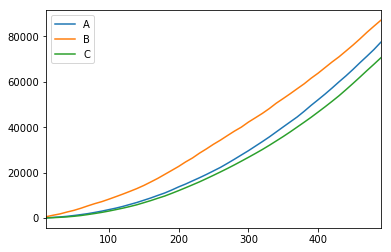

In [11]:
import pandas as pd
import matplotlib.pyplot as plt


indexes = [x[0] for x in cb__word2vec__coll]
values__cb__word2vec = [x[1] for x in cb__word2vec__coll]
values__cb__svd = [x[1] for x in cb__svd__coll]
values__word2vec__svd = [x[1] for x in word2vec__svd__coll]
values = zip(*[values__cb__word2vec, values__cb__svd, values__word2vec__svd])
df = pd.DataFrame(values, index=indexes, columns=list('ABC'))
df.plot()
plt.show()